
# Multi-objective Bayesian Optimization


TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
%reset -f
import numpy as np

import torch
from xopt import XoptBase, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, vocs

import pandas as pd

evaluator = Evaluator(evaluate_TNK)

generator = MOBOGenerator(vocs, n_initial=10, proximal_lengthscales=[1.0,1.0])
X = XoptBase(generator, evaluator, vocs)
X.step()

In [2]:
for i in range(50):
    print(f'step {i}')
    X.step()

step 0


/Users/chrisonian/Code/mambaforge/envs/xopt-dev/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1647804326539/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49


/Users/chrisonian/Code/mambaforge/envs/xopt-dev/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1647804326539/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


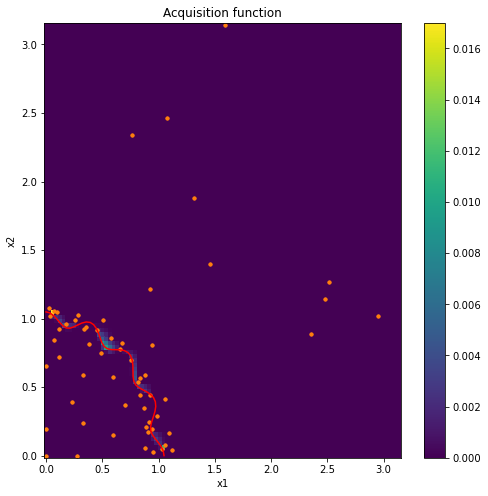

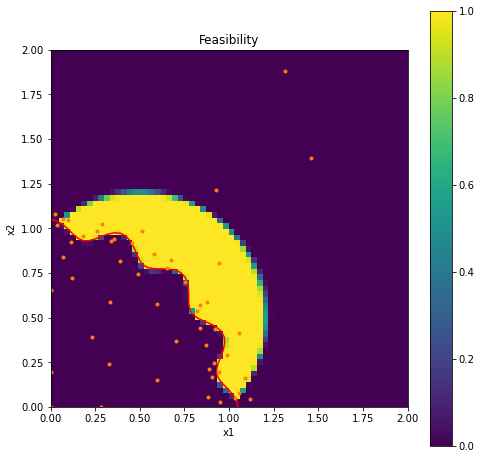

In [3]:
from xopt.generators.bayesian.utils import feasibility
from matplotlib import pyplot as plt# plot model predictions
bounds = vocs.bounds
history = X.data
model = generator.get_model(history)


n = 100
x = torch.linspace(*bounds.T[0],n)
y = torch.linspace(*bounds.T[1],n)
xx,yy = torch.meshgrid(x,y)
pts = torch.hstack([ele.reshape(-1,1) for ele in (xx,yy)]).double()

with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = X.generator.get_acquisition(model)(acq_pts)

    fig, ax = plt.subplots(figsize=(8,8))
    c = ax.pcolor(xx,yy,acq.reshape(n,n))
    fig.colorbar(c)
    ax.set_title('Acquisition function')

    ax.plot(*history[["x1","x2"]].to_numpy().T,'.C1')

    feas = feasibility(
        pts.unsqueeze(1),
        model,
        generator.options.acq.sampler,
        vocs
    ).flatten()

fig2, ax2 = plt.subplots(figsize=(8,8))
c2 = ax2.pcolor(xx,yy,feas.reshape(n,n))
fig2.colorbar(c2)
ax2.set_title('Feasibility')

ax.plot(*history[["x1","x2"]].to_numpy().T,'.C1')


theta = np.linspace(0,np.pi/2)
r = np.sqrt(1 + 0.1*np.cos(16*theta))
x_1 = r*np.sin(theta)
x_2_lower = r*np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5)**2)**0.5 + 0.5

z = np.zeros_like(x_1)
ax.plot(x_1, x_2_lower,'r')
ax2.plot(x_1, x_2_lower,'r')
ax2.plot(*history[["x1","x2"]].to_numpy().T,'.C1')
ax2.set_xlim(0, 2)
ax2.set_ylim(0, 2)
ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_aspect('equal')

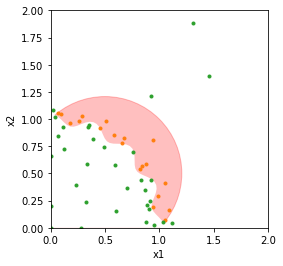

In [4]:

fig,ax = plt.subplots()

theta = np.linspace(0,np.pi/2)
r = np.sqrt(1 + 0.1*np.cos(16*theta))
x_1 = r*np.sin(theta)
x_2_lower = r*np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5)**2)**0.5 + 0.5

z = np.zeros_like(x_1)

#ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc='white')
circle = plt.Circle((0.5, 0.5), 0.5**0.5,
                    color='r', alpha=0.25, zorder=0,
                    label='Valid Region')
ax.add_patch(circle)
history = pd.concat([X.data, vocs.feasibility_data(X.data)], axis=1, ignore_index=False)

ax.plot(*history[["x1","x2"]][history["feasible"]].to_numpy().T,'.C1')
ax.plot(*history[["x1","x2"]][~history["feasible"]].to_numpy().T,'.C2')

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_aspect('equal')